# Analyse des tweets et articles pour la prédiction de la performance et volatilité du SP500

**Projet Python - 2A ENSAE** . 

Elena Loumagne / Jérémie Darracq 

## Introduction 

Objectifs : Il s'agit de prédire les performances et la volatilité du SP500 à partir du "sentiment du marché" 

Projet : il se découpe en trois parties 

- 1ère partie (voir notebook_récup_data_webscrapping /notebook_récup_data_API_finhub) : l'extraction des données sur la performance du SP500 (indice de performance SP500) et sa volatilité (indice VIX). La récupération des articles et des tweets en lien avec le SP500 via les API.   

- 2ème partie (notebook_récup_data_API_finhub) : le traitement des données incluant le nettoyage des tweets et des articles. 

- 3ème partie (notebook_analyse_data) : l'analyse des données par des statistiques descriptives, l'analyse de sentiment et construction du modèle de prédiction. 




## Sources

- Pour l'API finhub : https://python.plainenglish.io/access-historical-financial-news-headlines-with-python-be1b8faaea9f      
- Pour l'API twitter : https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178    
- Pour la prédiction : https://sentometrics-research.com/sentometrics/articles/applications/vix.html​




## Definitions 
- le "sentiment du marché" : renvoie à l’humeur générale des investisseurs sur un marché particulier. Le sentiment du marché a bien sûr un impact sur le cours du marché concerné. Lorsque le cours est en hausse, on dit souvent du sentiment du marché qu’il est haussier. Mais, lorsque le cours du marché est en baisse, on dit que le sentiment du marché est baissier. L’expression de « sentiment du marché » renvoie à l’émotion qui domine parmi les investisseurs d’un marché donné : par exemple, la peur ou l’optimisme.    
==> On tentera de l'identifier à travers notre base de donnée d'articles financiers sur les entreprises du SP500
- SP500 : indice boursier basé sur 500 grandes sociétés cotées sur les bourses aux États-Unis (NYSE ou NASDAQ). Il couvre environ 80 % du marché boursier américain par sa capitalisation.    
-  indice VIX : indicateur de volatilité du marché financier établit par le Chicago Board option Exchange.Le cours des options est considéré comme une bonne mesure de la volatilité car si quelque chose suscite de l’inquiétude sur le marché, les traders et les investisseurs ont tendance à se positionner à l’achat sur les options, ce qui entraîne une hausse des cours. C’est la raison pour laquelle le VIX est également appelé « indice de la peur », puisqu’il mesure le niveau de peur et de stress sur le marché.

- FINHUB : API fournissant des articles financiers concernant les plus grandes entreprises mondiales. 

## Import des packages 

In [74]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import imshow
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
import datetime
from wordcloud import WordCloud,STOPWORDS



## I - Exploration des données 

In [75]:
## On importe les articles propres 
article_data = pd.read_csv("Data/data_finhub.csv")

### Statistiques descriptives de la base d'articles financiers 

In [76]:
article_data.groupby("source")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()


,26,18,13,4,17,10,23,1,24,11,...,12,14,5,16,9,25,15,22,0,8
source,Yahoo,SeekingAlpha,MarketWatch,CNBC,Reuters,GuruFocus,Thefly.com,Alliance News,TipRanks,InvestorPlace,...,Market News Video,PR Newswire,Dividend Channel,Preferred Stock Channel,GlobeNewswire,United Press International,PennyStocks,The Online Investor,Accesswire,Fintel
abstract,5888,1819,1206,560,368,334,216,94,75,58,...,8,7,6,5,4,3,3,2,1,0


In [77]:
article_data.groupby("company")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,37,15,17,24,25,1,44,4,30,35,...,47,19,40,43,41,34,18,14,13,3
company,NVDA,COST,DIS,INTC,JNJ,AAPL,TSLA,AMZN,META,NFLX,...,WFC,FDX,PM,TMUS,SLB,NDAQ,EA,COF,CBOE,AIG
abstract,245,243,240,239,238,238,237,237,237,236,...,220,220,210,210,204,121,121,113,94,90


Des tableaux ci-dessus on constate que : 
- nos articles proviennent majoritairement des site Yahoo, SeekingAlpha et MarketWatch
- Les entreprises les plus citées sont Google et Méta mais les nombres de citations pour chaque entreprise est assez similaire

### Calcul du sentiment des articles à partir de la polarité

Ceci est fait grâce au package **SentimentIntensityAnalyzer** qui renvoie la polarité positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif.

In [78]:
sia = SentimentIntensityAnalyzer() # analiseur des sentiments


# ajout de mots spécifiques à la finance au lexique : moyenne du score de sentiment entre -4 (très négatif) et 4 (très positif)

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_words = {**dictOfpos, **dictOfneg} # déballage du dictionnaire

sia.lexicon.update(Financial_words)

In [79]:
article_data

,abstract,company,date,headline,source,abstract_clean,abstract_stemmed
0,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,10/05/22,Cboe Global Markets Reports Trading Volume for...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr..."
1,"NEW YORK, October 05, 2022--American Internati...",AIG,10/05/22,AIG to Report Third Quarter 2022 Financial Res...,Yahoo,"new york, october , --american international g...","new york, octob , --american intern group, inc..."
2,"Sony, Microsoft, Nintendo and Electronic Arts ...",EA,10/05/22,"The Zacks Analyst Blog Highlights Sony, Micros...",Yahoo,"sony, microsoft, nintendo electronic arts part...","sony, microsoft, nintendo electron art part za..."
3,Bearish flow noted in Ele... EA,EA,10/05/22,Electronic Arts put volume heavy and direction...,Thefly.com,bearish flow noted ele ea,bearish flow note ele ea
4,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,10/05/22,Cboe Joins Pyth Network to Bring Market Data t...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr..."
...,...,...,...,...,...,...,...
10902,"Why investing for the long run, especially if ...",CBOE,12/12/22,If You Invested $1000 in CBOE Global a Decade ...,Yahoo,"investing long run, especially buy certain pop...","invest long run, especi buy certain popular st..."
10903,Sales growth is vital for the survival of a bu...,CBOE,12/12/22,5 Stocks With Solid Sales Growth to Fight Econ...,Yahoo,"sales growth vital survival business, even eco...","sale growth vital surviv business, even econom..."
10904,"RAHWAY, N.J., December 12, 2022--Merck Begins ...",MRK,12/12/22,Merck Begins Tender Offer to Acquire Imago Bio...,Yahoo,"rahway, nj, december , --merck begins tender o...","rahway, nj, decemb , --merck begin tender offe..."
10905,"The sequel to movie box office champion ""Avata...",DIS,12/12/22,Expensive 'Avatar' sequel faces transformed mo...,Yahoo,"sequel movie box office champion ""avatar"" arri...","sequel movi box offic champion ""avatar"" arriv ..."


In [80]:
## On calcul le sentiment des résumés de chaque articles 
article_data["sentiment_score_abstract"]=article_data["abstract_stemmed"].apply(lambda x: sia.polarity_scores(str(x))['compound'])


Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet :

In [81]:
def article_label(score):
    if score > 0.00 :
        return "positif"
    if score < 0.00 :
        return "negatif"
    else :
        return "neutre"

def article_label_score(score):
    if score > 0.00 :
        return 1
    if score < 0.00 :
        return -1
    else :
        return 0

article_data["label_abstract"]=article_data["sentiment_score_abstract"].apply(article_label)
article_data["label_score_abstract"]=article_data["sentiment_score_abstract"].apply(article_label_score)
article_data


,abstract,company,date,headline,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,10/05/22,Cboe Global Markets Reports Trading Volume for...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr...",0.0000,neutre,0
1,"NEW YORK, October 05, 2022--American Internati...",AIG,10/05/22,AIG to Report Third Quarter 2022 Financial Res...,Yahoo,"new york, october , --american international g...","new york, octob , --american intern group, inc...",0.0000,neutre,0
2,"Sony, Microsoft, Nintendo and Electronic Arts ...",EA,10/05/22,"The Zacks Analyst Blog Highlights Sony, Micros...",Yahoo,"sony, microsoft, nintendo electronic arts part...","sony, microsoft, nintendo electron art part za...",0.2023,positif,1
3,Bearish flow noted in Ele... EA,EA,10/05/22,Electronic Arts put volume heavy and direction...,Thefly.com,bearish flow noted ele ea,bearish flow note ele ea,-0.7184,negatif,-1
4,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,10/05/22,Cboe Joins Pyth Network to Bring Market Data t...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr...",0.7184,positif,1
...,...,...,...,...,...,...,...,...,...,...
10902,"Why investing for the long run, especially if ...",CBOE,12/12/22,If You Invested $1000 in CBOE Global a Decade ...,Yahoo,"investing long run, especially buy certain pop...","invest long run, especi buy certain popular st...",0.9678,positif,1
10903,Sales growth is vital for the survival of a bu...,CBOE,12/12/22,5 Stocks With Solid Sales Growth to Fight Econ...,Yahoo,"sales growth vital survival business, even eco...","sale growth vital surviv business, even econom...",0.7506,positif,1
10904,"RAHWAY, N.J., December 12, 2022--Merck Begins ...",MRK,12/12/22,Merck Begins Tender Offer to Acquire Imago Bio...,Yahoo,"rahway, nj, december , --merck begins tender o...","rahway, nj, decemb , --merck begin tender offe...",0.0000,neutre,0
10905,"The sequel to movie box office champion ""Avata...",DIS,12/12/22,Expensive 'Avatar' sequel faces transformed mo...,Yahoo,"sequel movie box office champion ""avatar"" arri...","sequel movi box offic champion ""avatar"" arriv ...",0.8591,positif,1


#### Statistiques descriptives du sentiment des articles 

<AxesSubplot:xlabel='label_abstract', ylabel='Count'>

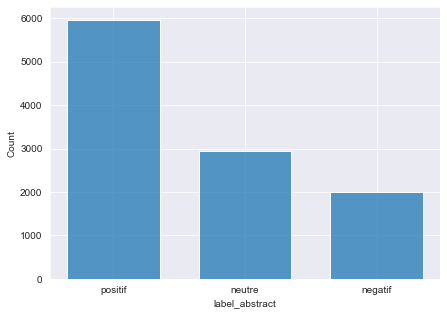

In [82]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(article_data.sort_values("label_abstract", ascending=False), x="label_abstract",  shrink=0.7)


#### Analyse temporelle

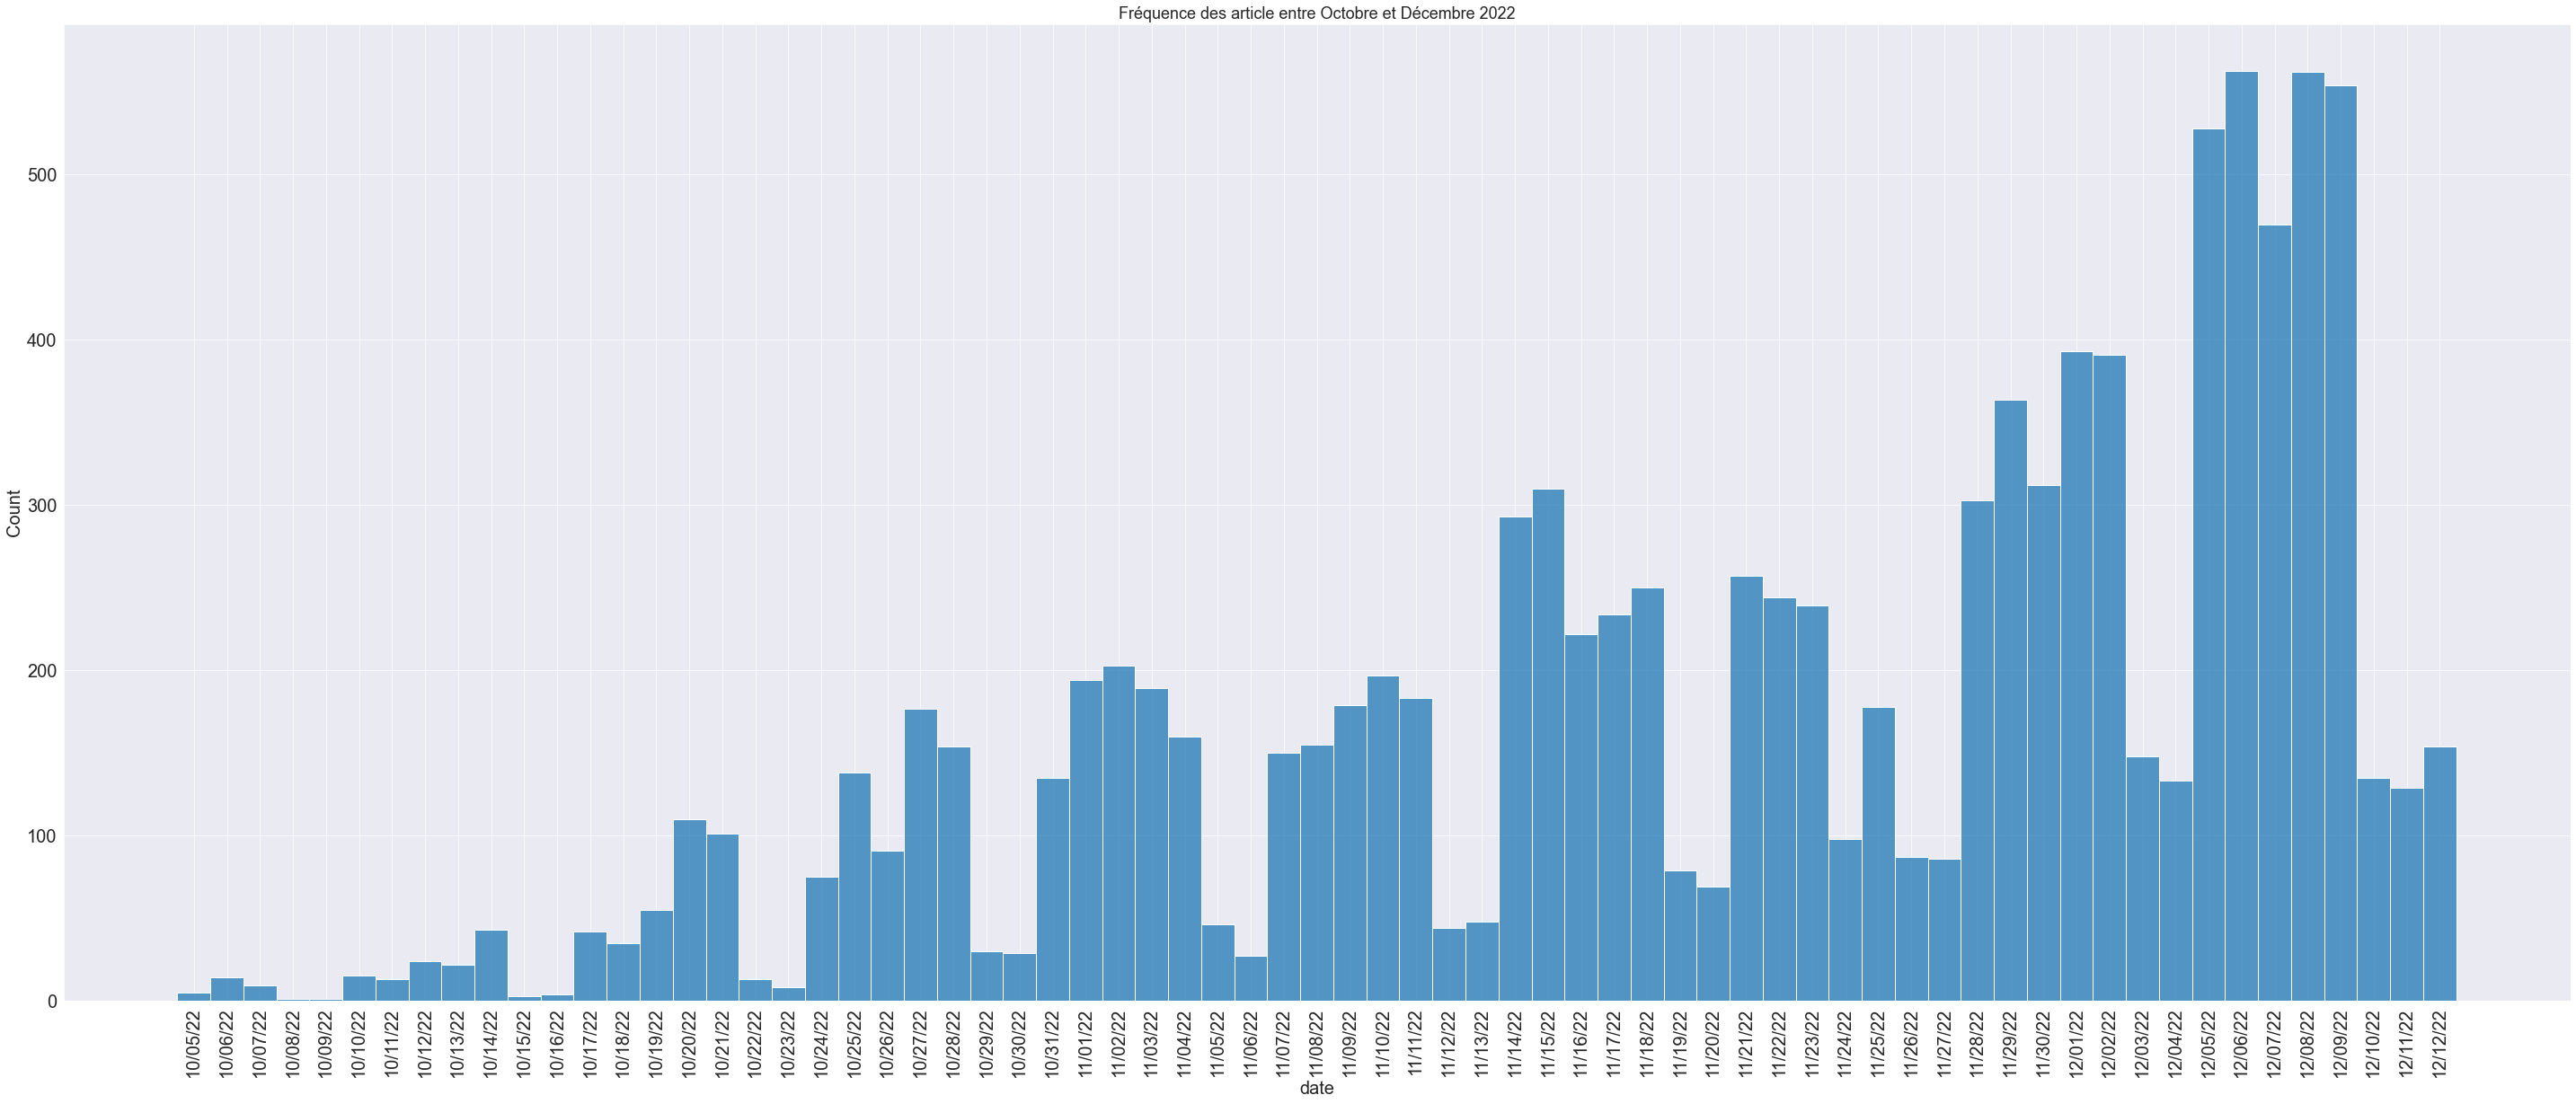

In [101]:
# Evolution de la fréquence des articles entre mars et Décembre 2022
cpalette = sns.diverging_palette(140, 10, n=3)
plt.figure(figsize=(50, 20))
sns.set_style('darkgrid')
sns.histplot(article_data, x="date")
plt.title("Fréquence des article entre Octobre et Décembre 2022", size=18)
plt.xticks(rotation = '90')
plt.show()



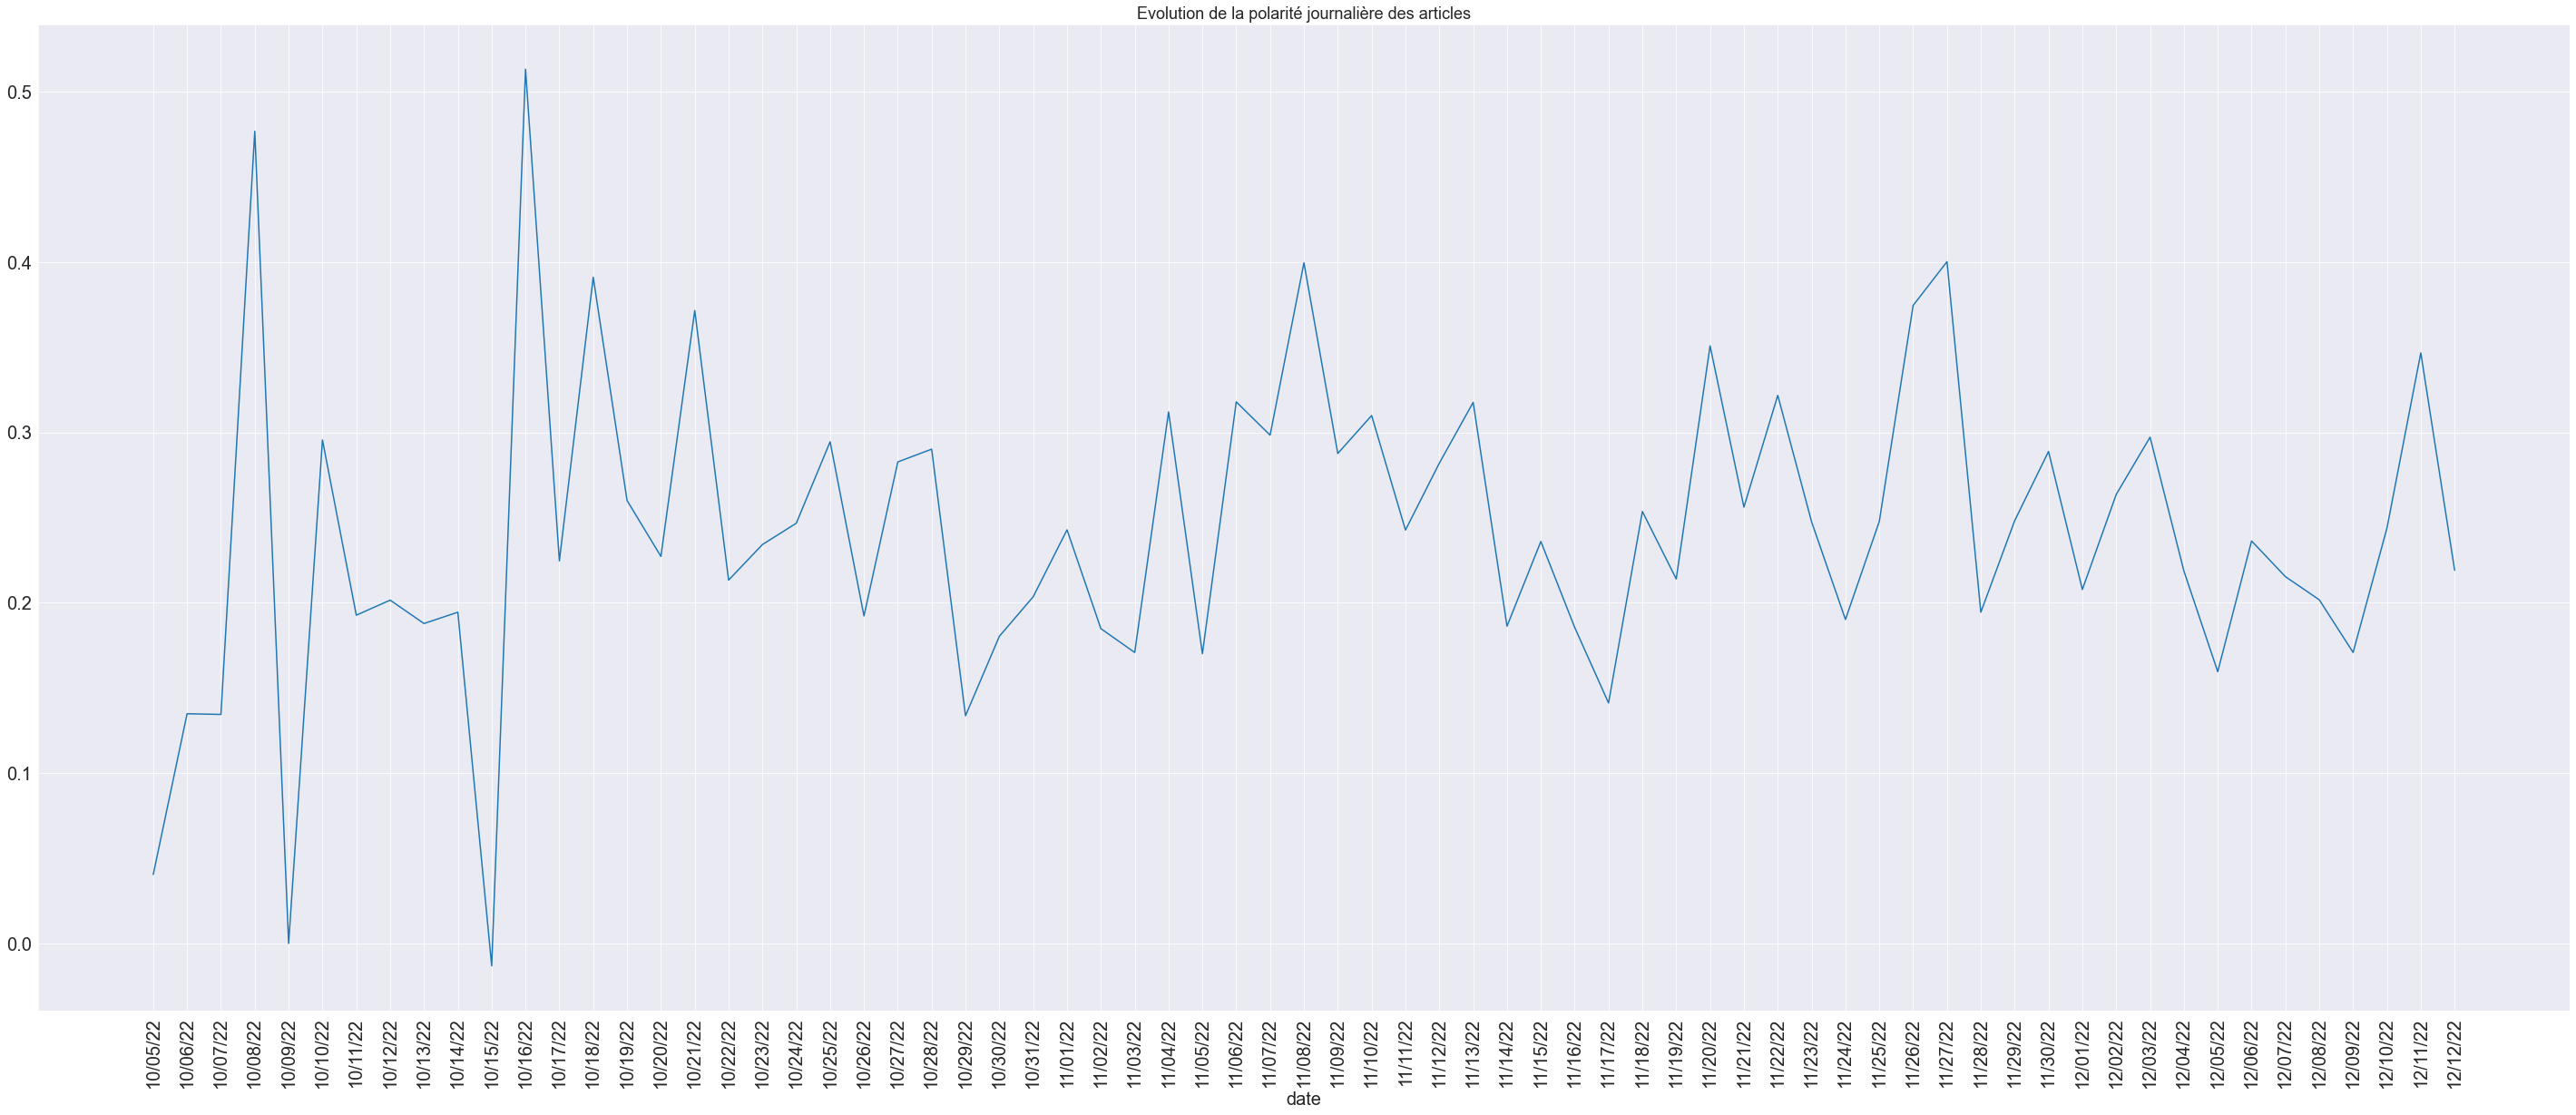

In [100]:
# Evolution de la polarité journalière des articles entre du 01 octobre 2022 au 5 décembre 2022
plt.figure(figsize=(50, 20))
plt.xlabel('date')
df2 = article_data[['date','sentiment_score_abstract']].groupby('date').mean()
plt.plot(df2)
plt.title("Evolution de la polarité journalière des articles", size=18)
plt.xticks(rotation='90')
plt.show()

Des tableaux ci-dessus on constate que : 
- La fréquence de nos articles est globalement entre 200 à 400 article par jour. 
- Il y a environ 3 fois plus d'articles positifs que négatifs et 2 fois plus d'articles positifs que neutres. 
- En moyenne, la polarité des articles est au dessus de 0 sur la période. 

### Relation entre le type de sentiment et les entreprises

In [65]:
cont=pd.crosstab(article_data["label_abstract"],article_data["company"])


<Figure size 7200x7200 with 0 Axes>

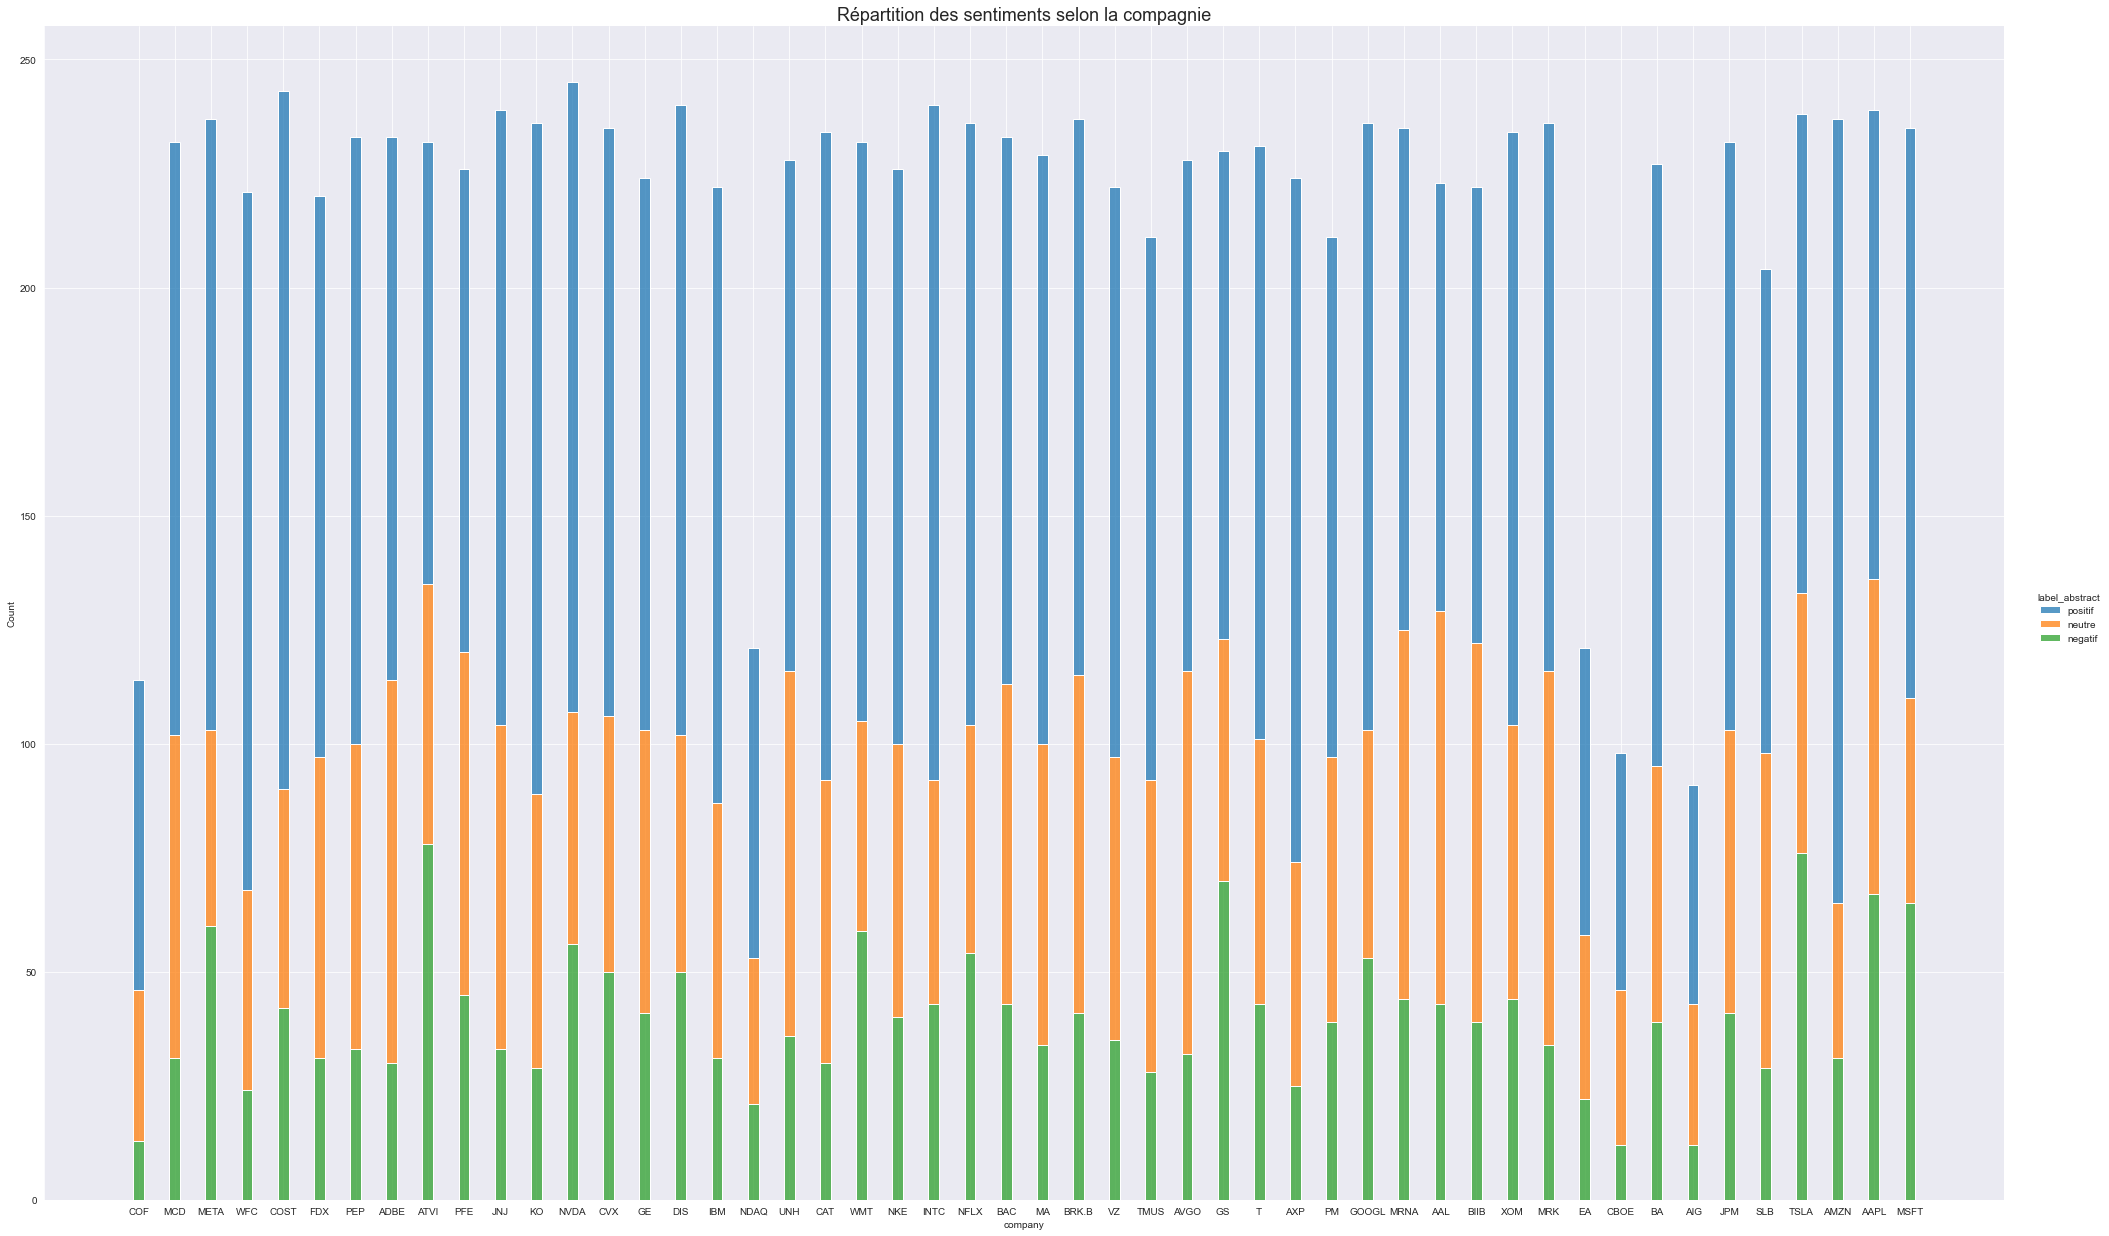

In [66]:
plt.figure(figsize=(100, 100))
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(article_data.sort_values("label_abstract", ascending=False), x="company", hue="label_abstract", multiple="stack", shrink=0.3,height=17, aspect=20/12)


plt.title("Répartition des sentiments selon la compagnie",size=18)
plt.show()

Du graphique ci-dessus on constate que : 
- les articles positifs représentent la plus grande part des articles citant les companies du SP500 suivis des articles neutres puis négatifs illustrant un possible "sentiment du marché" haussier sur la période choisie.
- la répartition des articles positifs, neutres et négatifs semblent relativement similaire ce qui suggère une indépendance entre le type de sentiment et la companie choisie. Cela illustrerait donc une sorte de tendance de marché / sentiment global du marché. 

Nous allons donc étudier la relation entre la variable "label_abtract" qui nous renseigne sur le type de sentiment et la variable "company" qui nous renseigne sur le type de company du SP500 à l'aide d'un test d'indépendance du Khi-deux et d'un test de Cramer.

### Test du Chi-deux et Test de Cramer 

- Test du Chi-deux : Il s'agit d'un test qui compare la distribution des modalités de deux variables qualitatives. L'hypothèse du test est l'indépendance entre les deux variables. L'hypothèse est rejetée si la statistique calculée est supérieure à la valeur critique correspondante. On peut également utiliser la p-valeur qui est comparée à un seuil de significativité. Dans ce cas, l'hypothèse nulle est rejetée si cette p-valeur est inférieure au seuil. il permet donc de savoir si les variables entretiennent une relation, avec un degré de certitude plus ou moins grand. Par contre, il ne renseigne pas sur l’intensité de cette relation et la p-valeur est très sensible à la taille de l'échantillon.

- Test de Cramer : Plus le V de Cramer s’approche de 1, plus l’intensité de la relation est forte.


In [67]:
## Réalisation du test du Chi-deux 
khi2, pval , ddl , contingent_theorique = chi2_contingency(cont)
print('statistic: ',khi2, '\nP-value: ',pval ,'\nddl: ', ddl)

statistic:  393.2455168088948 
P-value:  5.357422383319763e-37 
ddl:  98


In [68]:
## Fonction qui calcul le V de cramer 
def cramers(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = sum(crosstab.sum())
    return np.sqrt(chi2/(n*(min(crosstab.shape)-1)))

cramers(cont)

0.1342285240020641

Des résultats ci-dessus nous constatons que : 
- Au seuil de 5%, on rejette l'hypothèse nulle d'indépendance entre le type de sentiment et le type de companie du SP500 donc il existe toutefois une relation significative entre nos 2 variables quantitatives (test du Chi-deux )
- L'intensité de la relation reste cependant très faible voir nul, le V de cramer étant relativement proche de 0. 

Donc il semble possible que le type de sentiment des articles ne soit pas totalement liée à l'entreprise du SP500 qu'il considère mais possiblement à une tendance générale qu'on peut identifier comme le "sentiment du marché".

En suppossant, possible cette "tendance générale" / "sentiment de marché" nous allons voir si celle-ci peut nous permettre de prédire les performances/volatilité du SP500.

### Étude approfondies des sentiments des articles sur le SP500
On veut ici de visualiser les wordclouds selon le sentiment. Il ressort les mots redondants qui peuvent attirer l'attention sur un ou plusieurs aspects importants qui justifiraient le sentiment contenu dans les commentaires.

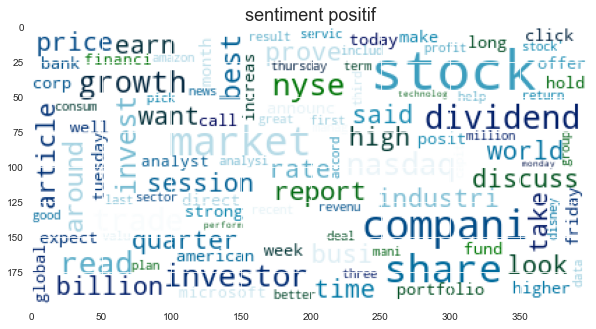

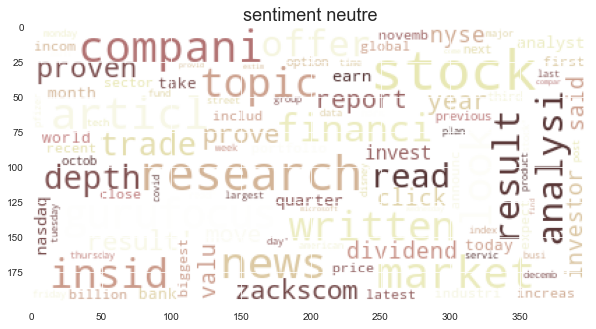

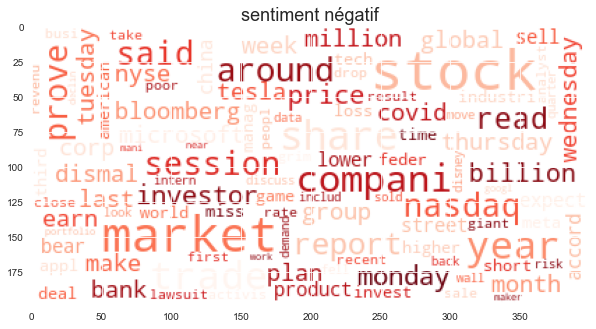

In [69]:
positive_article = []
negative_article = []
neutral_article = []

for i in range(0, article_data.shape[0]):
    if article_data['label_score_abstract'][i] == 0:
        neutral_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == 1:
        positive_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == -1:
        negative_article.append(article_data['abstract_stemmed'][i])

stopwords = set(STOPWORDS)

def show_wordcloud(data, sentiment,color):
    wordcloud = WordCloud(
        background_color='white',
        colormap=color,
        stopwords=stopwords,
        collocations=False, 
        collocation_threshold=100,
        max_words=100,
        max_font_size=40, 
        min_word_length=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    figure(1, figsize=(10, 10))
    imshow(wordcloud)
    plt.title("sentiment " + sentiment,size=18)
    plt.show()

show_wordcloud(positive_article,"positif","ocean_r")
show_wordcloud(neutral_article,"neutre",'pink_r')
show_wordcloud(negative_article,"négatif","Reds")

## II - Modèle de prédiction

### Identification du "sentiment du marché" 
On veut ici étudier la relation entre l'indice de performance du SP500 et le sentiment de nos articles.

### Régression linéaire 
Notre régression vise à expliquer l'indice de performance du SP500 à partir du "sentiment du marché" (identifié ici comme les "sentiments" de nos articles)


BROUILLON

In [70]:
## On importe les bases qu'on veut merge 
df_sp500 = pd.read_csv('Data/data_sp500.csv')
df_vix = pd.read_csv('Data/data_vix.csv')


In [71]:
## On modifie la date 
def modif_date(liste):
    liste_modif = liste[0:6]+'20'+liste[6:len(liste)]
    return liste_modif

article_data["date"]=article_data["date"].apply(lambda x : modif_date(x))
article_data

,abstract,company,date,headline,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,"On Thursday, October 27, 2022, at approximatel...",COF,10/05/2022,Capital One Financial Corporation to Webcast C...,Yahoo,"thursday, october , , approximately : pm easte...","thursday, octob , , approxim : pm eastern time...",0.7184,positif,1
1,Bearish flow noted in Ele... EA,EA,10/05/2022,Electronic Arts put volume heavy and direction...,Thefly.com,bearish flow noted ele ea,bearish flow note ele ea,-0.7184,negatif,-1
2,"Sony, Microsoft, Nintendo and Electronic Arts ...",EA,10/05/2022,"The Zacks Analyst Blog Highlights Sony, Micros...",Yahoo,"sony, microsoft, nintendo electronic arts part...","sony, microsoft, nintendo electron art part za...",0.2023,positif,1
3,"NEW YORK, October 05, 2022--American Internati...",AIG,10/05/2022,AIG to Report Third Quarter 2022 Financial Res...,Yahoo,"new york, october , --american international g...","new york, octob , --american intern group, inc...",0.0000,neutre,0
4,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,10/05/2022,Cboe Global Markets Reports Trading Volume for...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr...",0.0000,neutre,0
...,...,...,...,...,...,...,...,...,...,...
10908,U.S. known cases of COVID continued to rise st...,PFE,12/12/2022,"COVID cases continue upward march as new, more...",MarketWatch,us known cases covid continued rise steadily m...,us known case covid continu rise steadili mond...,-0.5423,negatif,-1
10909,Pfizer has a history of performing well during...,PFE,12/12/2022,Pfizer: The Best Long-Term Investment Setup Si...,SeekingAlpha,pfizer history performing well recessions bear...,pfizer histori perform well recess bear market...,0.2732,positif,1
10910,There shouldn't be negative surprises when Ado...,ADBE,12/12/2022,"Is Adobe Stock A Buy Before Earnings? Yes, Neg...",SeekingAlpha,negative surprises adobe reports fy earnings r...,negat surpris adob report fy earn read expect ...,0.0000,neutre,0
10911,The online car-buying site could be a great bu...,TSLA,12/12/2022,Carvana: Yahoo Finance's Worst Company of the ...,Yahoo,"online car-buying site could great business, o...","onlin car-buy site could great business, overe...",0.1531,positif,1


In [72]:
def convert(date_time):
    format = '%m/%d/%Y' 
    datetime_str = datetime.datetime.strptime(date_time, format)
 
    return datetime_str

article_data["date"]=article_data['date'].apply(lambda x : convert(x))


In [73]:
df_vix["date"]= df_vix["date"].astype('datetime64[ns]')
#df_sp500["date"]= df_sp500["date"].astype('datetime64[ns]')
article_data["date"]= article_data["date"].astype('datetime64[ns]')
article_data.sort_values(by="date")

,abstract,company,date,headline,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,"On Thursday, October 27, 2022, at approximatel...",COF,2022-10-05,Capital One Financial Corporation to Webcast C...,Yahoo,"thursday, october , , approximately : pm easte...","thursday, octob , , approxim : pm eastern time...",0.7184,positif,1
10,Shares of American International Group Inc. sl...,AIG,2022-10-05,American International Group Inc. stock falls ...,MarketWatch,shares american international group inc slumpe...,share american intern group inc slump $ wednes...,-0.3612,negatif,-1
9,The Fly is a leading digital publisher of real...,CBOE,2022-10-05,Home - The Fly,Thefly.com,fly leading digital publisher real-time financ...,fli lead digit publish real-tim financi news f...,0.0000,neutre,0
7,Cboe Global Markets annou... CBOE,CBOE,2022-10-05,Cboe Global Markets joins Pyth network,Thefly.com,cboe global markets annou cboe,cboe global market annou cboe,0.0000,neutre,0
6,(Bloomberg) -- Cboe Global Markets Inc. is mak...,CBOE,2022-10-05,Cboe Takes Step Into DeFi by Posting Free Mark...,Yahoo,(bloomberg) -- cboe global markets inc making ...,(bloomberg) -- cboe global market inc make rea...,0.6369,positif,1
...,...,...,...,...,...,...,...,...,...,...
10811,"Why investing for the long run, especially if ...",CBOE,2022-12-12,If You Invested $1000 in CBOE Global a Decade ...,Yahoo,"investing long run, especially buy certain pop...","invest long run, especi buy certain popular st...",0.9678,positif,1
10812,Sales growth is vital for the survival of a bu...,CBOE,2022-12-12,5 Stocks With Solid Sales Growth to Fight Econ...,Yahoo,"sales growth vital survival business, even eco...","sale growth vital surviv business, even econom...",0.7506,positif,1
10813,"RAHWAY, N.J., December 12, 2022--Merck Begins ...",MRK,2022-12-12,Merck Begins Tender Offer to Acquire Imago Bio...,Yahoo,"rahway, nj, december , --merck begins tender o...","rahway, nj, decemb , --merck begin tender offe...",0.0000,neutre,0
10806,"The sequel to movie box office champion ""Avata...",DIS,2022-12-12,Expensive 'Avatar' sequel faces transformed mo...,Yahoo,"sequel movie box office champion ""avatar"" arri...","sequel movi box offic champion ""avatar"" arriv ...",0.8591,positif,1
